In [1]:
import numpy as np
import torch
from speed_tests import PyTorch, NumPy
from torch.nn import MSELoss
import numpy.linalg as LA
from torch.autograd import Variable
import time
torch.__version__

'0.4.1'

In [2]:
import autograd
import autograd.numpy as anp

n, d = int(10e3), 1000
A = np.random.randn(n, d)
x = np.random.rand(d)
y = A @ x

def loss(x):
    return ((anp.dot(A, x) - y)**2).mean()

x_hat = np.random.rand(d)

In [3]:
%time g1 = autograd.grad(loss)(x_hat)

CPU times: user 28.6 ms, sys: 4.54 ms, total: 33.1 ms
Wall time: 22.3 ms


In [6]:
import autograd.numpy as anp

def torch_grad(A, x, y):
    mse = MSELoss()
    m = mse.forward(A @ x, y)
    m.backward()
    return x.grad / len(y)
        
def numpy_grad(A, x, y):
    return 2*(A.T@(A@x - y)) / len(y)

def hips_grad(A, x, y):
    loss = lambda x: ((anp.dot(A, x) - y)**2).sum() / len(y)
    return autograd.grad(loss)(x)

In [7]:
%time g2 = numpy_grad(A, x_hat, y)

CPU times: user 24.8 ms, sys: 2.21 ms, total: 27.1 ms
Wall time: 16.2 ms


In [8]:
def time_fn(fn, *args, limit=1, **kwargs):
    times = []
    start_time = time.time()
    while True:
        start = time.time()
        r = fn(*args, **kwargs)
        end = time.time()
        times += [end - start]
        if time.time() - start_time > limit:
            break
    if type(r) != np.ndarray:
        r = r.data.numpy()
    return {'result': r,
            'result_norm': np.linalg.norm(r),
            'time': min(times),
            'repeats': len(times)}

In [9]:
def time_fn_with_size(fn, n=None, d=10, seed=42, library='numpy'):
    np.random.seed(seed)
    n = 10*d
    A = np.random.randn(n, d)
    x = np.random.randn(d)
    y = A@x + n * 0.1 * np.random.randn(n)
    if library == 'pytorch':
        A = Variable(torch.from_numpy(A), requires_grad=False)
        y = Variable(torch.from_numpy(y), requires_grad=False)
        x = Variable(torch.from_numpy(x), requires_grad=True)
    return {'library': library,
            'seed': seed, 'n': n, 'd': d,
            **time_fn(fn, A, x, y)}

In [12]:
data = []

In [13]:
libraries = {'pytorch': torch_grad,
             'hips': hips_grad,
             'numpy': numpy_grad}

for repeat in range(10):
    for library, fn in libraries.items():
        print(repeat, fn)
        for d in np.logspace(1, np.log10(5e3), num=10, dtype=int):
            data += [time_fn_with_size(fn, d=d, seed=repeat, library=library)]

0 <function torch_grad at 0x115344048>
0 <function hips_grad at 0x115338d90>
0 <function numpy_grad at 0x115338f28>
1 <function torch_grad at 0x115344048>
1 <function hips_grad at 0x115338d90>
1 <function numpy_grad at 0x115338f28>
2 <function torch_grad at 0x115344048>
2 <function hips_grad at 0x115338d90>
2 <function numpy_grad at 0x115338f28>
3 <function torch_grad at 0x115344048>
3 <function hips_grad at 0x115338d90>
3 <function numpy_grad at 0x115338f28>
4 <function torch_grad at 0x115344048>
4 <function hips_grad at 0x115338d90>
4 <function numpy_grad at 0x115338f28>
5 <function torch_grad at 0x115344048>
5 <function hips_grad at 0x115338d90>
5 <function numpy_grad at 0x115338f28>
6 <function torch_grad at 0x115344048>
6 <function hips_grad at 0x115338d90>
6 <function numpy_grad at 0x115338f28>
7 <function torch_grad at 0x115344048>
7 <function hips_grad at 0x115338d90>
7 <function numpy_grad at 0x115338f28>
8 <function torch_grad at 0x115344048>
8 <function hips_grad at 0x115338

In [14]:
import pandas as pd
from altair import Chart
df = pd.DataFrame(data)
r = df.groupby(['n', 'library'])['result_norm']
df.to_csv('grad-timings.csv')
df.head()

,d,library,n,repeats,result,result_norm,seed,time
0,10,pytorch,100,6872,"[-13.993452430457022, 58.827503108203985, 91.4...",447.616537,0,0.000076
1,19,pytorch,190,6231,"[-114.80507999245879, 60.39931177814005, 132.0...",418.088224,0,0.000090
2,39,pytorch,390,4687,"[46.93297063343392, 39.055735210216575, 82.640...",298.833339,0,0.000114
3,79,pytorch,790,4859,"[34.53394542524026, -26.555283706704834, -32.8...",323.108401,0,0.000114
4,158,pytorch,1580,3387,"[-21.439180838175083, 17.049971053693675, -24....",202.051514,0,0.000217


In [15]:
import pandas as pd
import numpy as np
df = pd.read_csv('grad-timings.csv')

In [16]:
show = df.pivot_table(index='d', columns='library', values='time',
                      aggfunc=np.min)
show

library,hips,numpy,pytorch
d,,,
10,0.000229,0.000005,0.000071
19,0.000243,0.000009,0.000081
39,0.000257,0.000013,0.000091
79,0.000286,0.000026,0.000105
158,0.000414,0.000070,0.000202
315,0.001216,0.000651,0.000942
629,0.003572,0.002911,0.003172
1256,0.012818,0.011895,0.012271
2506,0.053713,0.052277,0.054989


In [51]:
import matplotlib.pyplot as plt

In [24]:
show["d"] = show.index
s = show.melt(id_vars="d")
s["time (s)"] = s["value"]
s.head()

,d,library,value,time (s)
0,10,hips,0.000229,0.000229
1,19,hips,0.000243,0.000243
2,39,hips,0.000257,0.000257
3,79,hips,0.000286,0.000286
4,158,hips,0.000414,0.000414


Index(['Unnamed: 0', 'd', 'library', 'n', 'repeats', 'result', 'result_norm',
       'seed', 'time'],
      dtype='object')


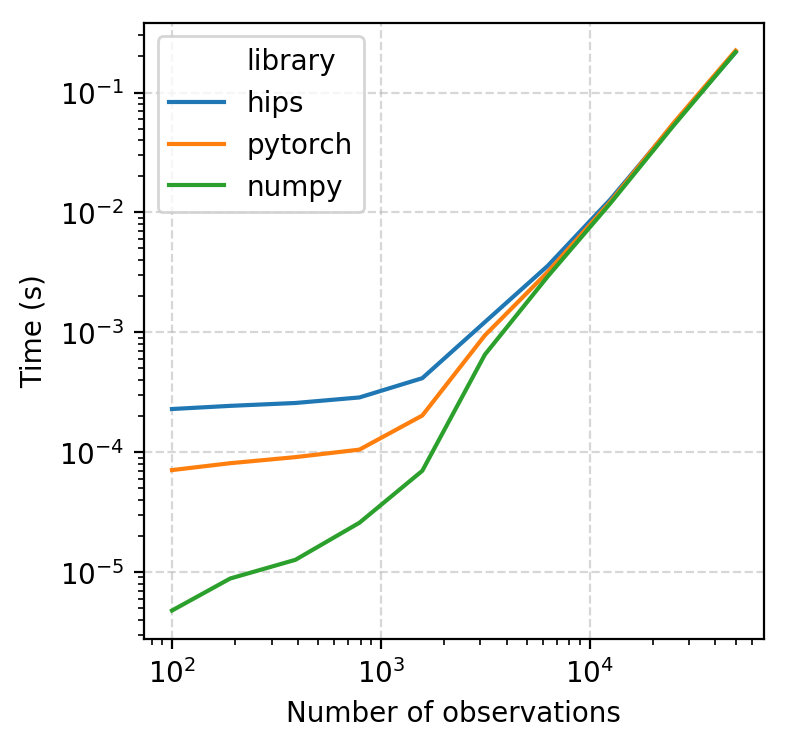

In [58]:
import seaborn as sns
print(df.columns)
s = df[["d", "library", "n", "repeats", "time"]]

fig, ax = plt.subplots(figsize=(4, ) * 2)
ax = sns.lineplot(
    data=s,
    x="n",
    y="time",
    hue="library",
    hue_order=["hips", "pytorch", "numpy"],
    estimator=np.min,
    ci=None,
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of observations")
ax.grid(linestyle="--", alpha=0.5)
plt.savefig('grad-timings.svg', bbox_inches='tight')

In [59]:
!open .

In [34]:
df.head()

,Unnamed: 0,d,library,n,repeats,result,result_norm,seed,time
0,0,10,pytorch,100,6872,[ -13.99345243 58.82750311 91.40426769 -9...,447.616537,0,0.000076
1,1,19,pytorch,190,6231,[-114.80507999 60.39931178 132.03786879 -3...,418.088224,0,0.000090
2,2,39,pytorch,390,4687,[ 46.93297063 39.05573521 82.6409679 -3...,298.833339,0,0.000114
3,3,79,pytorch,790,4859,[ 34.53394543 -26.55528371 -32.84569021 9.55...,323.108401,0,0.000114
4,4,158,pytorch,1580,3387,[-21.43918084 17.04997105 -24.36146001 7.15...,202.051514,0,0.000217


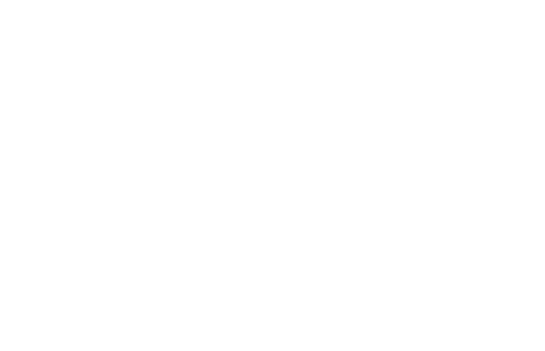

In [28]:

import altair as alt
alt.Chart(s).mark_line().encode(
    x=alt.X("d", scale=alt.Scale(type="log")),
    y=alt.Y("time (s)", scale=alt.Scale(type="log")),
    color="library",
).interactive()

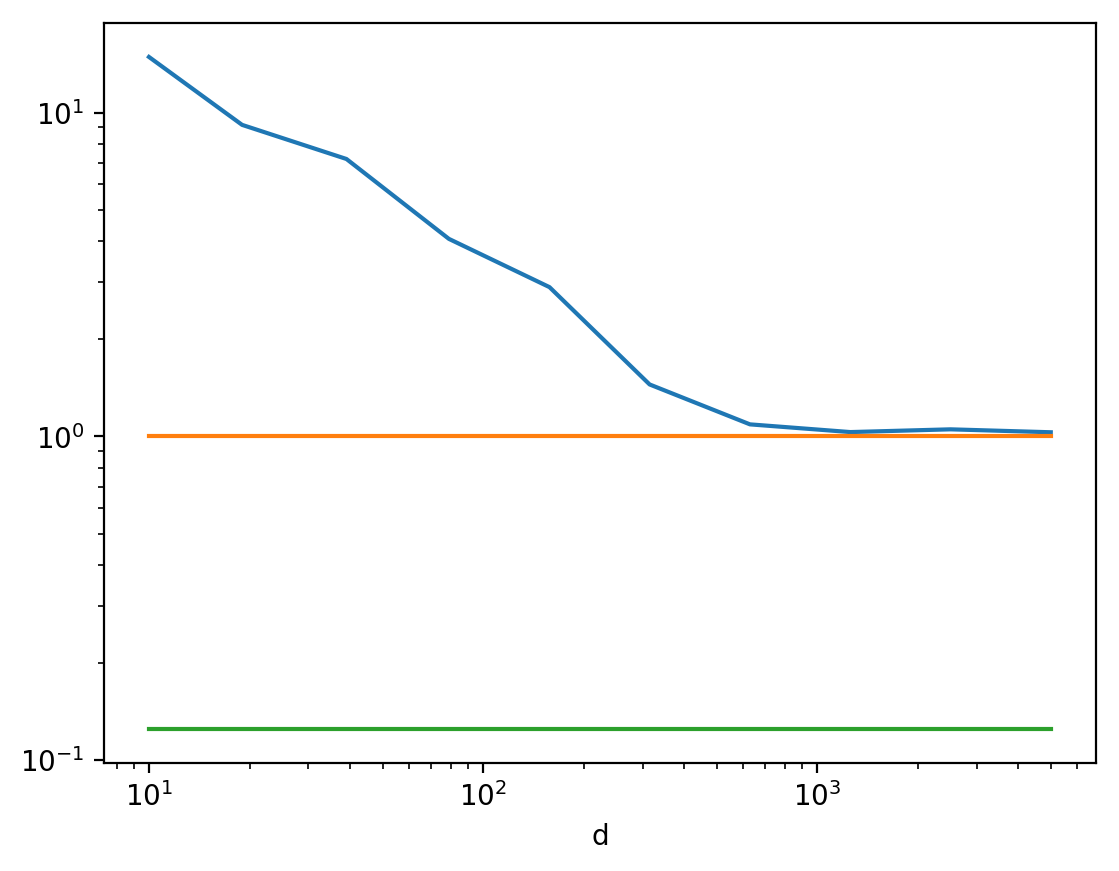

In [18]:
speedup = show['pytorch'] / show['numpy'] 
speedup.plot(logx=True, logy=True)
plt.plot([show.index.min(), show.index.max()], [1, 1])
# because I have 8 cores on this system
plt.plot([show.index.min(), show.index.max()], [1/8, 1/8])